In [ ]:
import pandas as pd
import scipy
import numpy as np
from scipy import stats, special

import tensorflow as tf
print(tf.__version__)
sess = tf.InteractiveSession()

import tfnb

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Hyperparameters

In [2]:
N_z = 50  # Latent variables
N_h = 100 # Neurons in non-final hidden layer(s)
N_bottleneck = 50 # Neurons in final hidden layer

# Data

In [3]:
# Data
x_array = np.array(pd.read_csv("x.csv"))
y_array = np.array(pd.read_csv("y.csv"))
site_array = (np.array(pd.read_csv("site.csv"))) - 1 # Zero-indexing versus R's one-indexing
obs_array = (np.array(pd.read_csv("obs.csv"))) - 1   # Zero-indexing

# Sizes
N_x = x_array.shape[1]
N_y = y_array.shape[1]

N_s = int(np.max(site_array[:,1])) + 1 # Include zero as a column
N_o = int(np.max(obs_array[:,1])) + 1  # Include zero as a column
N_rows = x_array.shape[0]

# Placeholders
N = tf.placeholder(tf.int32, shape=[]) # Minibatch size
Y = tf.placeholder(tf.float32, shape=[None, N_y]) # Response variables
X = tf.placeholder(tf.float32, shape=[None, N_x]) # Predictor variables
SO = tf.sparse_placeholder(tf.float32, shape=[None, N_s + N_o]) # Random effect design matrix; sites then observers

# Layer 0: calculate random effects & concatenate with X

In [4]:
# Declare variables for layer 0
W0_mu = tfnb.make_weights(N_s + N_o,N_z)
W0_sigma = tfnb.make_weights(N_s + N_o,N_z)
b0_mu = tf.Variable(tf.zeros(N_z))
b0_sigma = tf.Variable(0.25 * tf.ones(N_z)) 

# Sample from latent density (Z)
mu0 = tf.sparse_tensor_dense_matmul(SO,W0_mu) + b0_mu
sigma0 = tf.nn.softplus(tf.sparse_tensor_dense_matmul(SO,W0_sigma) + b0_sigma)
epsilon = tf.random_normal(tf.shape(mu0))
Z = mu0 + sigma0 * epsilon

# Define layer 1's inputs with X and Z
XZ = tf.concat([X,Z], 1)

# Hidden layers

In [5]:
# Declare variables
W1 = tfnb.make_weights(N_z + N_x, N_h)
W2 = tfnb.make_weights(N_h, N_bottleneck)
b1 = tf.Variable(tf.zeros(N_h))
b2 = tf.Variable(tf.zeros(N_bottleneck))

# Feed forward
H1 = tf.contrib.layers.layer_norm(tf.matmul(XZ, W1) + b1, 
                                  activation_fn=tf.nn.elu)
H2 = tf.contrib.layers.layer_norm(tf.matmul(H1, W2) + b2, 
                                  activation_fn=tf.nn.elu)
HN = H2

# Output layer

In [6]:
# Declare variables: output is 3X as wide as y to accomodate mu, size, and zi_p
WN = tfnb.make_weights(N_bottleneck, N_y * 3) / 3.
# Mean, then size, then zi_p
bN_mu = tf.Variable(np.log(np.mean(y_array, axis=0) + 0.1), dtype = tf.float32)
bN_size = tf.Variable(scipy.special.logit(np.mean(y_array!=0, axis=0)) / 2 - 1, 
                      dtype = tf.float32)
bN_p_inf = tf.Variable(scipy.special.logit((np.mean(y_array == 0, axis=0))) / 5.0, 
                       dtype = tf.float32)
bN = tf.concat((bN_mu,bN_size,bN_p_inf), 0)

# For convenience, give names to the three pieces of WN
WN_mu, WN_size, WN_zi_p = tf.split(WN, 3, 1)

linear_predictors = tf.split(tf.matmul(HN, WN) + bN, 3, 1)


# Softplus to keep mu and size non-negative; sigmoid to keep zi_p in (0,1)
nb_mu = tf.nn.softplus(linear_predictors[0])
nb_size = tf.nn.softplus(linear_predictors[1])
zi_p = tf.sigmoid(linear_predictors[2])

# Switch to N,p parameterization for negative binomial
nb_p = nb_size / (nb_mu + nb_size)

# Loss & Optimizer

In [7]:
# For fitting loop
rows = np.arange(y_array.shape[0])
n_steps = 0.
t = tf.placeholder(dtype=tf.float32)

def make_minibatch(n):
    rows = np.arange(N_rows)
    if n!=N_rows:
        np.random.shuffle(rows)
    rows = rows[range(n)]
    
    # Coordinates of nonzero entries in sparse design matrix.
    # one site and one observer per row
    i = np.concatenate((np.arange(n), np.arange(n)))
    j = np.concatenate((site_array[rows,1], obs_array[rows,1]))

    return {X:x_array[rows,:], 
           Y:y_array[rows,:], 
           SO:(np.vstack((i,j)).transpose(), [1] * (2 * n), [n, N_s + N_o]), 
           N:n, 
           t:n_steps}

prediction_loss = -tf.reduce_sum(tfnb.zi_nbinom_ll(Y, nb_size, nb_p, zi_p))

# Put a prior on negative binomial's "p" and the zero-inflation parameter, 
# which both cause numerical problems at 0 or 1
# Also, weight decay on everything that's not already regularized by KL.
prior_loss = tfnb.gaussian_loss(tfnb.logit(nb_p), 0, 5, clip=0.1) +\
                tfnb.gaussian_loss(tfnb.logit(zi_p), 0, 5, clip=0.1) +\
                tfnb.gaussian_loss(W1, 0, 10.0, clip = 0.01) +\
                tfnb.gaussian_loss(W2, 0, 10.0) +\
                tfnb.gaussian_loss(WN_mu, 0, 5.0) +\
                tfnb.gaussian_loss(WN_size, 0, 1.0) +\
                tfnb.gaussian_loss(WN_zi_p, 0, 1.0)

variational_loss = tfnb.kl(mu0, sigma0)

# Don't pay too much for the KL/entropy term until a few thousand iterations in, when
# the network has started to settle down a bit.
total_loss = prediction_loss + prior_loss +\
                variational_loss * (1 - tf.exp(-t / 50000.))
loss = total_loss / tf.cast(N, tf.float32)

adam = tf.train.AdamOptimizer();
train_step = adam.minimize(loss);

In [8]:
# Session incantations 
init = tf.global_variables_initializer()
sess.run(init)

# Model-fitting loop

In [9]:
# Fit the model
n = 32

for i in range(1000000):
    if n_steps % 1000 == 0:
        raw_losses = sess.run([prediction_loss, prior_loss, variational_loss, N_rows * loss], 
                              feed_dict=make_minibatch(N_rows))
        print(np.round([loss / N_rows for loss in raw_losses], 4))
    sess.run(train_step, feed_dict=make_minibatch(n))
    n_steps += 1
print(n_steps)

[ 331.9682    0.5129    1.6933  332.4812]
[ 222.033     2.207     9.8228  224.4346]
[ 209.4713    1.899    21.9049  212.2292]


KeyboardInterrupt: 

# Downstream analyses

0.1018739

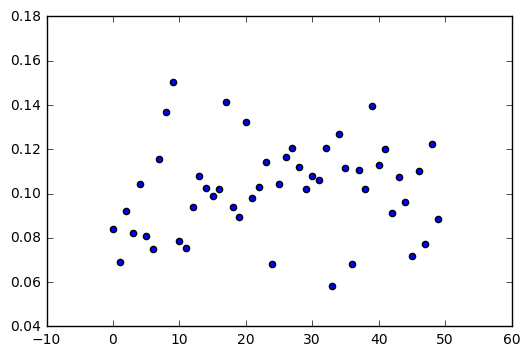

In [10]:
mus, sigmas = sess.run((mu0, sigma0), feed_dict=make_minibatch(N_rows))
plt.scatter(range(N_z), np.mean(mus**2, axis = 0));
np.var(mus)

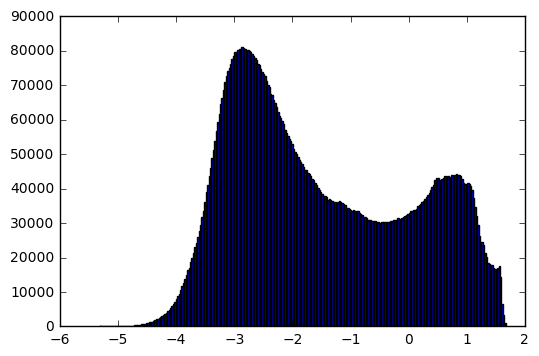

In [11]:
plt.hist(np.log10(np.ndarray.flatten(sess.run(nb_mu, feed_dict=make_minibatch(N_rows)))), bins = "fd");

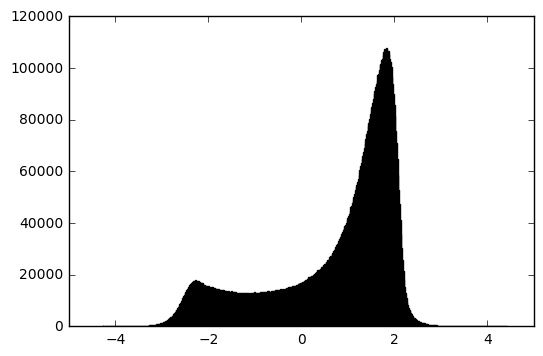

In [12]:
plt.hist(sess.run(tfnb.logit(zi_p), feed_dict=make_minibatch(N_rows)).flatten(), bins = "fd");

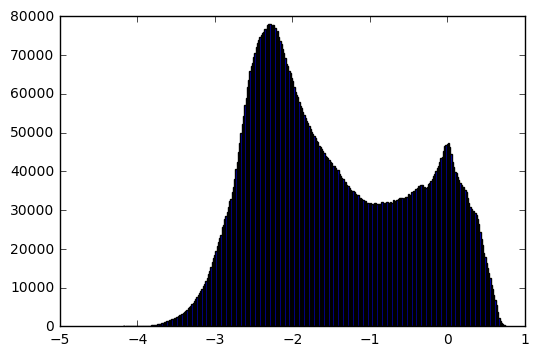

In [13]:
plt.hist(np.log10(sess.run(nb_size, feed_dict=make_minibatch(N_rows)).flatten()), bins = "fd");

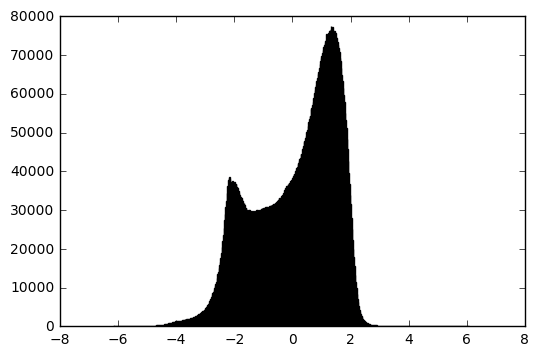

In [14]:
plt.hist(scipy.special.logit(sess.run(nb_p, feed_dict=make_minibatch(N_rows)).flatten()), bins = "fd");

In [15]:
print(np.sqrt(np.mean(sess.run(tf.square(W0_mu)))))
print(np.sqrt(np.mean(sess.run(tf.square(W0_sigma)))))
print(np.sqrt(np.mean(sess.run(tf.square(W1)))))
print(np.sqrt(np.mean(sess.run(tf.square(W2)))))
print(np.sqrt(np.mean(sess.run(tf.square(WN_mu)))))
print(np.sqrt(np.mean(sess.run(tf.square(WN_size)))))
print(np.sqrt(np.mean(sess.run(tf.square(WN_zi_p)))))

0.125724
0.0552031
0.141184
0.1511
0.116165
0.0418197
0.0378221


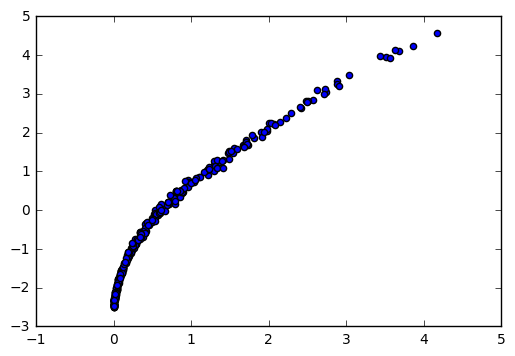

In [16]:
plt.scatter(np.log(np.mean(y_array, axis=0) + 1), 
            bN_mu.eval());

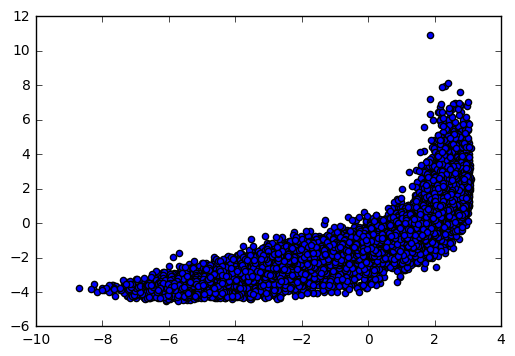

In [17]:
plt.scatter(sess.run(tf.log(nb_mu[:,3]), feed_dict=make_minibatch(N_rows)),
             sess.run(tfnb.logit(nb_size[:,3]), feed_dict=make_minibatch(N_rows)));

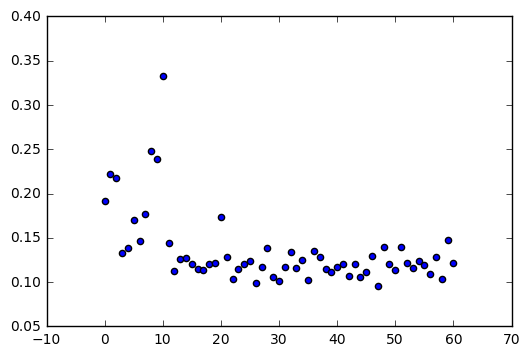

In [18]:
plt.scatter(range(N_z + N_x), np.sqrt(np.mean(W1.eval()**2, axis=1)))

In [19]:
all_mu, all_zip = sess.run((nb_mu, zi_p), feed_dict=make_minibatch(N_rows))
np.savetxt("mu.csv", all_mu, delimiter=",")
np.savetxt("zip.csv", all_zip, delimiter=",")

In [20]:
print(n_steps)

2699.0


In [21]:
sess.run([tfnb.gaussian_loss(tfnb.logit(nb_p), 0, 5, clip=0.1)/ N_rows,
                tfnb.gaussian_loss(tfnb.logit(zi_p), 0, 5, clip=0.1)/ N_rows], 
                              feed_dict=make_minibatch(N_rows)) 

[1.2223151, 0.50584751]